# Try to pull something coherent together for a paper

In [1]:
%cd /g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory

/g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory


In [2]:
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from src import data, utils, ar_model

import warnings

warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
matplotlib.rcParams["figure.figsize"] = (14, 6)
matplotlib.rcParams["font.size"] = 12
matplotlib.rcParams["axes.grid"] = True

In [5]:
DATA_DIR = "../../data/processed/"

## Load some SST data to play with

#### Reanalysis data

In [6]:
def prep_data(ds):
    """Some steps to prepare some data"""

    # Annual
    ds = ds.coarsen(time=12, boundary="trim", coord_func="max").mean().compute()
    ds = ds.assign_coords({"time": ds.time.dt.year})

    # 5x5 deg grid
    ds = data.interpolate_to_regular_grid(ds, 5)

    # Anomalies
    ds = ds - ds.mean("time")

    # Detrend
    ds = utils.detrend(ds)

    return ds

In [7]:
reanalysis = prep_data(xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True))

#### CMIP6 historical data

In [8]:
model = "HadGEM3-GC31-MM"

historical = prep_data(
    xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_historical.zarr", use_cftime=True)
)

#### Mask the land

In [9]:
mask = (
    reanalysis["sst"].sum("time", skipna=False).notnull()
    & historical["tos"].sum(["time", "member"], skipna=False).notnull()
)

reanalysis = xr.where(mask, reanalysis, 0)
historical = xr.where(mask, historical, 0)

## Fit an AR model to timeseries at each point

In [10]:
reanalysis_params = ar_model.fit(
    reanalysis, n_lags="select_order", kwargs={"maxlag": 10}
)

In [11]:
historical_params = ar_model.fit(
    historical, n_lags="select_order", kwargs={"maxlag": 10}
)

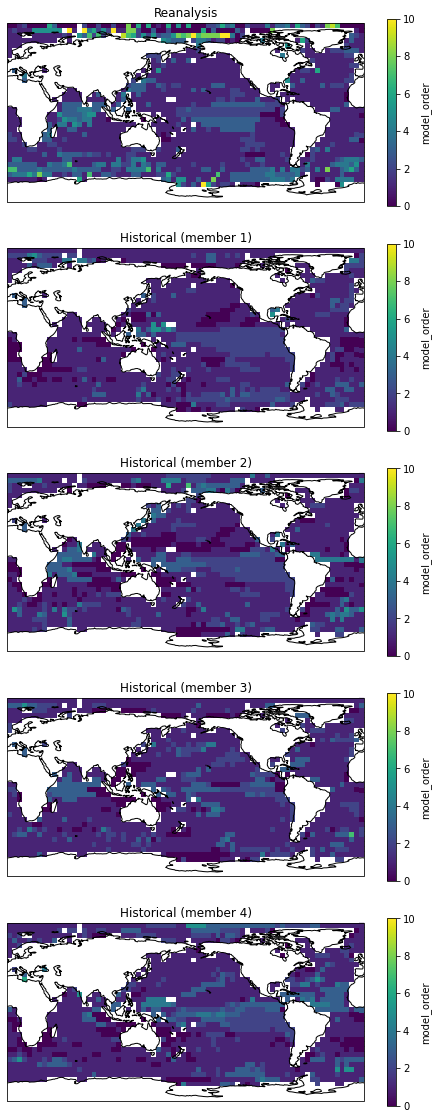

In [12]:
fig = plt.figure(figsize=(8, 20))
axs = fig.subplots(
    1 + historical.sizes["member"], 1, subplot_kw=dict(projection=ccrs.PlateCarree(180))
)


def plot_field(ds, ax):
    p = ds.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=0,
        vmax=10,
    )

    p.axes.set_global()
    p.axes.coastlines()


ax = axs[0]
plot_field(reanalysis_params["model_order"].where(mask), ax)
ax.set_title("Reanalysis")

for idx, mem in enumerate(historical_params.member):
    ax = axs[idx + 1]
    plot_field(historical_params["model_order"].sel(member=mem).where(mask), ax)
    ax.set_title(f"Historical (member {mem.values})")

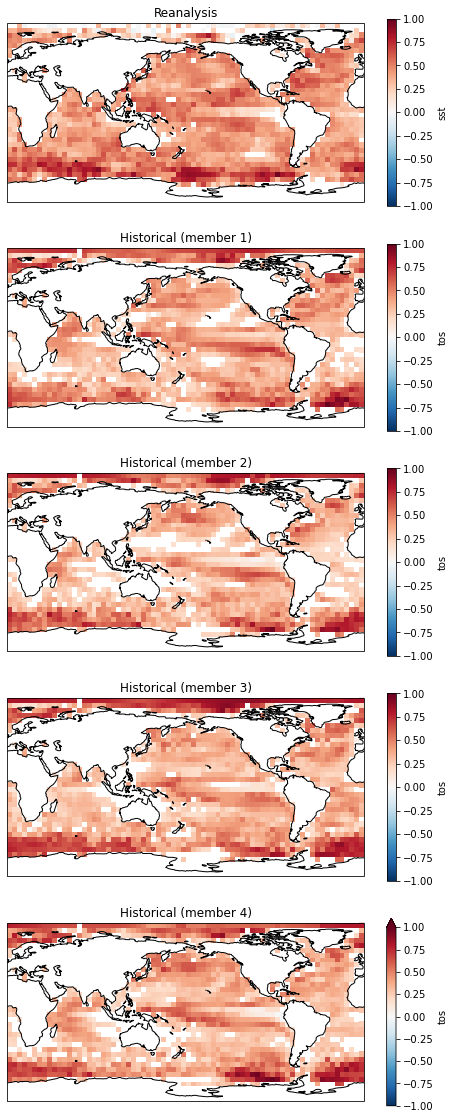

In [13]:
fig = plt.figure(figsize=(8, 20))
axs = fig.subplots(
    1 + historical.sizes["member"], 1, subplot_kw=dict(projection=ccrs.PlateCarree(180))
)


def plot_field(ds, ax):
    p = ds.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap="RdBu_r")

    p.axes.set_global()
    p.axes.coastlines()


ax = axs[0]
plot_field(reanalysis_params["sst"].sel(params="sst.lag1"), ax)
ax.set_title("Reanalysis")

for idx, mem in enumerate(historical_params.member):
    ax = axs[idx + 1]
    plot_field(historical_params["tos"].sel(params="tos.lag1").sel(member=mem), ax)
    ax.set_title(f"Historical (member {mem.values})")

## Generate samples from the AR model fit at each point. Let's just focus on the reanalysis params for now

In [182]:
inits = ar_model.generate_samples(
    reanalysis_params, n_times=reanalysis.sizes["time"], n_samples=3
)

In [183]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

In [289]:
a = np.arange(720).reshape(2, 6, 5, 4, 3)
b = np.arange(90).reshape(6, 5, 3, 1)

In [290]:
samples = predict(
    reanalysis_params,  # .isel(lat=18, lon=32),
    inits,  # .isel(lat=18, lon=32),
    n_steps=4,
    n_members=5,
)

<xarray.Dataset>
Dimensions:      (lon: 72, lat: 36, sample: 3, init: 143, member: 5, lead: 4)
Coordinates:
  * lon          (lon) float64 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
  * lat          (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
    area         (lon, lat) float64 1.346e+10 4.028e+10 ... 4.028e+10 1.346e+10
    model_order  (lon, lat) int64 0 0 0 0 1 3 7 3 1 1 1 ... 0 0 0 0 1 1 1 1 0 0
  * sample       (sample) int64 0 1 2
Dimensions without coordinates: init, member, lead
Data variables:
    sst          (sample, lon, lat, init, member, lead) float32 0.0 ... 0.000...


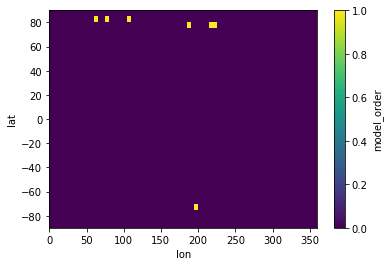

In [264]:
(reanalysis_params["model_order"] == 10).plot()

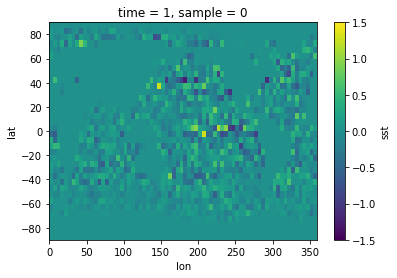

In [278]:
inits.isel(sample=0, time=0)["sst"].plot(vmin=-1.5, vmax=1.5)

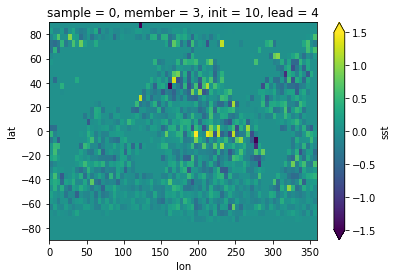

In [287]:
samples.isel(sample=0, init=0, member=3, lead=3)["sst"].T.plot(vmin=-1.5, vmax=1.5)

In [71]:
import numpy as np

a = np.arange(36).reshape(2, 2, 3, 3)
b = np.arange(12).reshape(2, 3, 2)

In [133]:
import numpy as np

a = np.arange(720).reshape(2, 6, 5, 4, 3)
b = np.arange(90).reshape(6, 5, 3, 1)

In [111]:
6 * 5 * 3 * 1

90

In [41]:
b[0].shape

(3,)

In [57]:
a[1, 1].shape

(3, 3)

In [58]:
b[1].shape

(3,)

In [54]:
(a[1, 1] @ b[1])

array([338, 374, 410])

In [56]:
b.shape

(2, 3)

In [134]:
test = np.matmul(a, b)

In [135]:
test.shape

(2, 6, 5, 4, 1)

In [49]:
test

array([[[[  5],
         [ 14],
         [ 23]],

        [[122],
         [158],
         [194]]],


       [[[ 59],
         [ 68],
         [ 77]],

        [[338],
         [374],
         [410]]]])

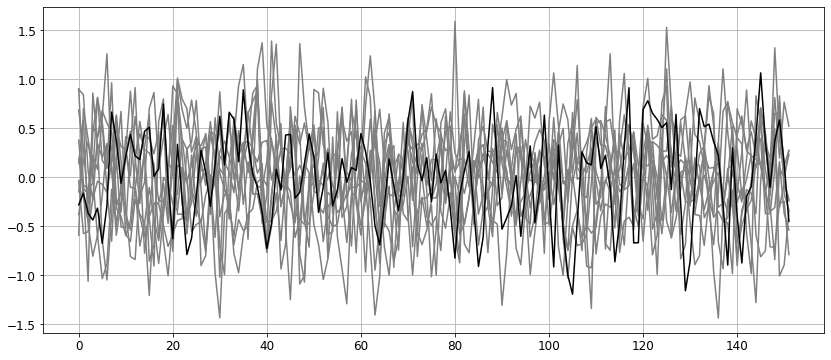

In [281]:
plt.plot(samples.isel(lat=18, lon=36), color="grey")
plt.plot(reanalysis["sst"].isel(lat=18, lon=36), color="k")

In [283]:
samples

<xarray.DataArray 'sst' (lat: 36, lon: 72, time: 152, sample: 10)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
           2.90959096e-03,  3.28282709e-03,  9.06220172e-04],
         [ 4.83305985e-03, -2.06330582e-03, -1.07134576e-03, ...,
           9.58673947e-04, -1.37972925e-03, -2.43920134e-04],
         [-1.92224130e-03, -1.85833615e-03, -3.97571921e-06, ...,
          -2.19010212e-03, -4.56971829e-05,  5.02773153e-04]],

        [[ 1.75659871e-03,  1.41223765e-03,  1.74201431e-03, ...,
           5.13048784e-04, -2.23495372e-04,  1.62770890e-03],
         [-1.10128522e-03, -1.08580338e-03, -6.36886456e-04, ...,
           1.61190762e-03,  2.35493109e-03,  2.31411611e-03],
         [-4.13628113e-05,  2.05804221e-03, -3.85127321e-04, ...,
          -4.53229481e-03,  1.11387766e-04,  1.49143406e-03],
         ...,
         [ 3.31010728e-04, -5.32972626e-03, -2.47720163e-04, ...,
           2.68241065e-03,  1.43235386e-03, -3.02404328e-03],
         [ 5.73981612e-04,  1.28244876e-03,  8.26175732e-04, ...,
          -3.15666985e-04, -1.30029779e-03, -2.92032049e-03],
         [-2.09451187e-03,  2.19112588e-03, -4.17197531e-04, ...,
           1.32996927e-03, -3.24667967e-03, -5.38542029e-03]]]],
      dtype=float32)
Coordinates:
  * lon          (lon) float64 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
  * lat          (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
    area         (lat, lon) float64 1.346e+10 1.346e+10 ... 1.346e+10 1.346e+10
    model_order  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 2 1 8 9 7 0 0 0 0 0
  * time         (time) int64 1 2 3 4 5 6 7 8 ... 146 147 148 149 150 151 152
  * sample       (sample) int64 0 1 2 3 4 5 6 7 8 9